# Проект для «Викишоп» 

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<a id='content'></a>

<div> 

**Содержание**:

* <a href='#know_the_data'>Загрузка данных</a> </br>          
* <a href='#data_preprocessing'>Предобработка данных</a> </br>     
* <a href='#model_training'>Обучение модели</a> </br>                    
* <a href='#testing'>Тестирование</a></br>                        
* <a href='#conclusions'>Выводы</a></br>                          


</div>

## Загрузка данных

 <a id='know_the_data'></a>

In [1]:
!pip install --upgrade scikit-learn==1.2.2 -q matplotlib==3.9.0 -q

In [2]:
!pip install pandas==2.2.2 seaborn==0.13.2 numba==0.60.0 numpy==1.26.4  -q

In [3]:
!pip install pymystem3 -q

In [4]:
import re
import warnings

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import transformers
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from matplotlib import pyplot as plt
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from tqdm import notebook, tqdm
tqdm.pandas()


# Загрузка ресурсов NLTK (один раз)
nltk.download("wordnet")
nltk.download("punkt")

# Игнорирование предупреждений
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/irinamistulova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/irinamistulova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
try:
        df = pd.read_csv('../assets/toxic_comments.csv') 
except:
        df = pd.read_csv('/datasets/toxic_comments.csv') 
    
pd.set_option("display.max_columns", None)
df.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
display(pd.DataFrame(df.isna().mean()*100).round(2)
            .style.background_gradient('coolwarm'))

,0
Unnamed: 0,0.000000
text,0.000000
toxic,0.000000


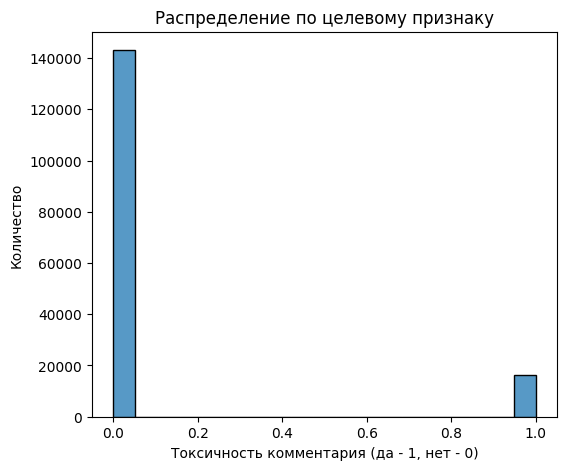

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))  # Use 'ax' instead of 'axes'
sns.histplot(df, x='toxic', ax=ax)  # Use 'ax' here as well
ax.set_title('Распределение по целевому признаку')
ax.set_ylabel('Количество')
ax.set_xlabel('Токсичность комментария (да - 1, нет - 0)')
plt.show()

In [ ]:
df['Unnamed: 0'].unique()

array([     0,      1,      2, ..., 159448, 159449, 159450])

In [10]:
df=df.drop(columns= ['Unnamed: 0'])
df.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


**Выводы**

- Пропуски отсутсвуют
- Столбец дублирующий интексы удален
- Текс на английском языке, будет использован словарь стоп слов на английском
- Целевой признак имеет дисбаланс классов. Поэтому целесообразнее для оценки модели использовать метрику F1-мера: среднее гармоническое между precision и recall. Также для устранения дибаланса будет использован Undersampling (уменьшение выборки), т.к. будет использоваться кросс-валидация и оверсемплинг не подойдет.

<a href='#content'>Вернуться к оглавлению</a> 

## Подготовка данных

<a id='data_preprocessing'></a> 

- Лемматизируем твиты из колонки text, 
- удалим из предложений стоп слова, которые не несут важной информации для прогнозирования. 
- удалим знаки припинания и приведем все к нижнему регистру, для того, чтобы уменьшить объем матрицы, при переводе текста в векторный вид.

In [11]:
test = df['text'][4]
test

"You, sir, are my hero. Any chance you remember what page that's on?"

In [12]:
test_re = re.sub(r'[^a-zA-Z\s]+', ' ', test.lower())
test_re

'you  sir  are my hero  any chance you remember what page that s on '

In [13]:
test_tags = nltk.pos_tag(test_re.split())
test_tags

[('you', 'PRP'),
 ('sir', 'VBP'),
 ('are', 'VBP'),
 ('my', 'PRP$'),
 ('hero', 'NN'),
 ('any', 'DT'),
 ('chance', 'NN'),
 ('you', 'PRP'),
 ('remember', 'VBP'),
 ('what', 'WP'),
 ('page', 'NN'),
 ('that', 'WDT'),
 ('s', 'VBZ'),
 ('on', 'IN')]

In [14]:
nltk.download('wordnet', quiet=True)  
nltk.download('stopwords', quiet=True)  
nltk.download('averaged_perceptron_tagger', quiet=True) 

lemmatizer = WordNetLemmatizer()
stop_words = set(nltk_stopwords.words('english'))

def lemmatize_and_remove_stopwords(text):
   
    text = re.sub(r'[^a-zA-Z\s]+', ' ', text.lower())
    words_with_tags = nltk.pos_tag(text.split())  # POS tags
    lemmatized_words = []

    for word, tag in words_with_tags:
        if word not in stop_words:
            if tag.startswith('J'):
                pos = 'a'  # Adjective
            elif tag.startswith('V'):
                pos = 'v'  # Verb
            elif tag.startswith('N'):
                pos = 'n'  # Noun
            elif tag.startswith('R'):
                pos = 'r'  # Adverb
            else:
                pos = None  # Use default WordNet lemmatization (noun)

            lemma = lemmatizer.lemmatize(word, pos=pos) if pos else lemmatizer.lemmatize(word)
            lemmatized_words.append(lemma)

    return " ".join(lemmatized_words)

In [15]:
tqdm.pandas()
df['lemmatized_text'] = df['text'].progress_apply(lemmatize_and_remove_stopwords)
df.head(10)

100%|██████████| 159292/159292 [04:24<00:00, 603.28it/s]


,text,toxic,lemmatized_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation edits make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please remove template talk page since retire
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,aww match background colour seemingly stick thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man really try edit war guy constantly remove relevant information talk edits instead talk page seem care formatting actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format etc later one else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn list relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,congratulation well use tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,vandalism matt shirvington article revert please ban
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0,sorry word nonsense offensive anyway intend write anything article wow would jump vandalism merely request encyclopedic one use school reference selective breeding page almost stub point animal breeding short messy article give info must someone around expertise eugenics
9,alignment on this subject and which are contrary to those of DuLithgow,0,alignment subject contrary dulithgow


Проверим тексты на наличие дубликатов

In [16]:
print('Размер до удаления дубликатов:', df.shape)
df = df.drop_duplicates(keep = 'first', subset='lemmatized_text')
print('Размер после удаления дубликатов:', df.shape)

Размер до удаления дубликатов: (159292, 3)
Размер после удаления дубликатов: (157364, 3)


In [17]:
df = df.reset_index(drop=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157364 entries, 0 to 157363
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             157364 non-null  object
 1   toxic            157364 non-null  int64 
 2   lemmatized_text  157364 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


Текст необходимо представить в векторном виде. Для этого будем использовать 
TF-IDF (учет контектса частичный, за счет учета редкости слова, различает важность слов, требования в вычислительной мощности выше, чем у мешка слов, но ниже чем у BERT)

**Выводы**

- Тексты лемматизированы
- Удалены стоп-слова
- Удалены дубликаты

<a href='#content'>Вернуться к оглавлению</a> 

## Обучение

<a id='model_training'></a> 

Мы решаем задачу классификации с учителем. Будем обучать модель логистической регрессии на двух подготовленных входных признаках. В качестве оценки будем использовать F1-меру - это  гармоническое среднее между precision и recall. F1-мера стремится к максимуму, когда precision и recall сбалансированы.

In [19]:
X = df['lemmatized_text']
y= df['toxic']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                    y, 
                                    test_size=0.25, 
                                    random_state=42)
corpus = list(X_train)

In [21]:
tf_idf_vector =TfidfVectorizer() 
X_train = tf_idf_vector.fit_transform(corpus)
X_test = tf_idf_vector.transform(X_test)

print("Размер матрицы X_train:", X_train.shape)
print("Размер матрицы X_test:", X_test.shape)

Размер матрицы X_train: (118023, 132000)
Размер матрицы X_test: (39341, 132000)


In [22]:
feature_names = tf_idf_vector.get_feature_names_out()
feature_names[18000:18050]

array(['carinatus', 'caring', 'carington', 'carioca', 'carion',
       'carisbrook', 'caristii', 'carit', 'carjacker', 'carl', 'carla',
       'carlaude', 'carle', 'carlebach', 'carles', 'carleton',
       'carletons', 'carlie', 'carlile', 'carlin', 'carling',
       'carlingford', 'carlinhos', 'carlisle', 'carlito', 'carlmarche',
       'carlo', 'carload', 'carlos', 'carlossuarez', 'carlotta',
       'carlsbad', 'carlsberg', 'carlsen', 'carlson', 'carlsruhe',
       'carlsson', 'carlton', 'carly', 'carlyn', 'carma', 'carmack',
       'carmaker', 'carman', 'carmarthen', 'carmarthenshire',
       'carmegenon', 'carmel', 'carmelite', 'carmen'], dtype=object)

In [23]:
X_train.data

array([0.28586946, 0.29821648, 0.19951923, ..., 0.08646987, 0.10543201,
       0.09145243])

Нормализация не требуется

In [24]:

# Пайплайн с выбором модели через GridSearch
pipeline = Pipeline([
    ('classifier', LogisticRegression())  # Плейсхолдер для модели
])

# Параметры для RandomizedSearch
parameters = [
    {  # Для LogisticRegression
        'classifier': [LogisticRegression(random_state=42, max_iter=5000)],
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    },
     {  # Для SGDClassifier
        'classifier': [SGDClassifier(class_weight='balanced', 
                                     max_iter=5000, 
                                     random_state=42)],
        'classifier__loss': ['hinge'],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__alpha': [0.0001, 0.001, 0.01],
        'classifier__learning_rate': ['constant', 'optimal'],
        'classifier__eta0': [0.001, 0.01]
    }

]

# Настройка RandomizedSearch
rs = RandomizedSearchCV(
    pipeline,
    parameters,
    n_iter=20,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [25]:
%%time
model = rs.fit(X_train, y_train)
print(model.best_params_)
model.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classifier=SGDClassifier(class_weight='balanced', max_iter=5000, random_state=42), classifier__alpha=0.01, classifier__eta0=0.01, classifier__learning_rate=constant, classifier__loss=hinge, classifier__penalty=l2; total time=   0.8s
[CV] END classifier=SGDClassifier(class_weight='balanced', max_iter=5000, random_state=42), classifier__alpha=0.01, classifier__eta0=0.01, classifier__learning_rate=constant, classifier__loss=hinge, classifier__penalty=l2; total time=   0.9s
[CV] END classifier=SGDClassifier(class_weight='balanced', max_iter=5000, random_state=42), classifier__alpha=0.01, classifier__eta0=0.01, classifier__learning_rate=constant, classifier__loss=hinge, classifier__penalty=l2; total time=   0.9s
[CV] END classifier=SGDClassifier(class_weight='balanced', max_iter=5000, random_state=42), classifier__alpha=0.01, classifier__eta0=0.01, classifier__learning_rate=constant, classifier__loss=hinge, classifier__p

0.7654929642114626

In [26]:
result = pd.DataFrame(model.cv_results_).sort_values(by='rank_test_score')
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__penalty,param_classifier__loss,param_classifier__learning_rate,param_classifier__eta0,param_classifier__alpha,param_classifier,param_classifier__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,15.480827,1.053044,0.052427,0.015897,l2,NaN,NaN,NaN,NaN,"LogisticRegression(C=10, max_iter=5000, random_state=42)",10,"{'classifier__penalty': 'l2', 'classifier__C': 10, 'classifier': LogisticRegression(C=10, max_iter=5000, random_state=42)}",0.758505,0.771273,0.773358,0.762808,0.761520,0.765493,0.005781,1
5,0.677389,0.149648,0.022750,0.004974,l2,hinge,optimal,0.001,0.0001,"SGDClassifier(class_weight='balanced', max_iter=5000, random_state=42)",NaN,"{'classifier__penalty': 'l2', 'classifier__loss': 'hinge', 'classifier__learning_rate': 'optimal', 'classifier__eta0': 0.001, 'classifier__alpha': 0.0001, 'classifier': SGDClassifier(class_weight='balanced', max_iter=5000, random_state=42)}",0.752486,0.746930,0.739978,0.737325,0.733174,0.741979,0.006901,2
13,1.326940,0.266048,0.076025,0.015506,l2,hinge,optimal,0.01,0.0001,"SGDClassifier(class_weight='balanced', max_iter=5000, random_state=42)",NaN,"{'classifier__penalty': 'l2', 'classifier__loss': 'hinge', 'classifier__learning_rate': 'optimal', 'classifier__eta0': 0.01, 'classifier__alpha': 0.0001, 'classifier': SGDClassifier(class_weight='balanced', max_iter=5000, random_state=42)}",0.752486,0.746930,0.739978,0.737325,0.733174,0.741979,0.006901,2
14,2.122878,0.272319,0.097656,0.086938,l2,hinge,constant,0.01,0.0001,"SGDClassifier(class_weight='balanced', max_iter=5000, random_state=42)",NaN,"{'classifier__penalty': 'l2', 'classifier__loss': 'hinge', 'classifier__learning_rate': 'constant', 'classifier__eta0': 0.01, 'classifier__alpha': 0.0001, 'classifier': SGDClassifier(class_weight='balanced', max_iter=5000, random_state=42)}",0.749673,0.745302,0.736478,0.736745,0.735513,0.740742,0.005693,4
4,1.576771,0.160482,0.030513,0.009464,l1,hinge,optimal,0.001,0.0001,"SGDClassifier(class_weight='balanced', max_iter=5000, random_state=42)",NaN,"{'classifier__penalty': 'l1', 'classifier__loss': 'hinge', 'classifier__learning_rate': 'optimal', 'classifier__eta0': 0.001, 'classifier__alpha': 0.0001, 'classifier': SGDClassifier(class_weight='balanced', max_iter=5000, random_state=42)}",0.736289,0.731990,0.723174,0.726632,0.713230,0.726263,0.007910,5


**Выводы**

- Было рассмотрено 2 модели (Логистической регрессии и Линейная SVM, использующая стахостический градиентный спуск для оптимизации)
- Для каждой модели подобраны гиперпараметры.
- В качестве метрики используется F1. Критерий оценки должен быть не ниже 0.75 (условие заказчика) 
- Смещение модели менее 1.5%, что свидетельствует о том, что модель не переобучена/недообучена.


Для тестовой оценки выбрана модель логистической регрессии с гиперпараметрами 'C': 10, 'penalty': 'l2'. В которой текст представляется в векторном виде с использованием tf idf

<a href='#content'>Вернуться к оглавлению</a> 

## Тестирование модели

<a id='testing'></a> 

Проверим точность модели на тестовой выборке

In [27]:
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("Метрика f1 на тестовой выборке", f1.round(2))

Метрика f1 на тестовой выборке 0.78


**Выводы**

- Ошибка на тестовой выборке 0.78, выше нижней требуемой границы.
- Модель быстро обучается и делает предсказания.

<a href='#content'>Вернуться к оглавлению</a> 

## Выводы


На основании предоставленной информации можно сделать следующие выводы о проделанной работе и полученных результатах:

**1. Предобработка данных:**

*   Проведена тщательная предобработка текстовых данных, включающая лемматизацию, удаление стоп-слов и дубликатов. Это важный шаг для улучшения качества обучения модели.
*   Корпус текстов был очищен от пропусков и дублирующихся индексов.

**2. Векторизация текста:**

*   Тексты были успешно преобразованы в векторный вид c помощью векторизации TF-IDF. Это позволило использовать тексты в моделях машинного обучения.

**4. Обучение моделей:**

*   Для решения задачи были обучены модель логистической регрессии и стахостического спуска с функцией потерь модели опорных векторов. С помощью RandomizedSearch и кросс валидации подобраны гиперпараметры моделей.
*   

**5. Выбор модели:**

*   Обоснованно выбрана модель логистической регрессии с гиперпараметрами С: 10 и регуляризацией l2, обученая на признаках TF-IDF.

**6. Тестирование модели:**

*   На тестовой выборке модель показала результат F1-меры 0.78, что превышает минимально требуемый порог 0.75. Это свидетельствует о хорошей обобщающей способности модели.

**7. Производительность модели:**

*   Отмечено быстрое обучение модели и высокая скорость предсказания, что является важным фактором для практического применения.

**Общий вывод:**

Получена модель классификации текстов, удовлетворяющая требованиям заказчика по качеству (F1-мера выше 0.75) и производительности. 

**Рекомендации:**

*   Несмотря на хорошие результаты, всегда есть возможность для улучшения. Можно попробовать использовать другие методы векторизации текста (например, BERT) и сравнить результаты.
*   Для дальнейшего улучшения модели можно рассмотреть возможность использования более сложных моделей классификации, таких как градиентный бустинг.


<a id='conclusions'></a> 

<a href='#content'>Вернуться к оглавлению</a> 